<a href="https://colab.research.google.com/github/bmercer486/tam470-tutorials/blob/main/bvp_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use the direct method to solve $y''(x) = f(x)$

## The ODE

Let's solve:

$$y''(x) = 10\cos\left(\dfrac{\pi x}{L}\right), \quad x\in[0, L]$$

With boundary conditions:

$$y'(0) = \phi, \quad y(L) = y_N$$.

The exact solution is easily obtained by integraing the RHS twice and finding the constants of integration that satisfy the boundary conditions; the exact solution is

$$y_{exact} = -\dfrac{10L^2}{\pi^2}\cos\left(\dfrac{\pi x}{L}\right) + C_1x + C_2$$

With $C_1 = \phi$ and $C_2 = -y_N - \dfrac{10L}{\pi^2} - \phi L$

Using the central difference scheme in class for the ODE $y'' + A(x)y' + B(x)y = f(x)$, we derived the following scheme:

$$\gamma_j y_{j-1} + \beta_j y_j + \alpha_j y_{j+1} = f_j, \quad j = 1, 2, ..., N-1$$

For the first node (first row of equations), we write
$$\beta_1 y_1 + \alpha_1 y_{2} = f_1 - \gamma_1 y_{0}$$

For the last node (last row of equations), we write
$$\gamma_{N-1} y_{N-2} + \beta_{N-1} y_{N-1} = f_{N-1} - \alpha_{N-1} y_{N}$$

Where

$$\alpha_j = \left(\dfrac{1}{h^2} + \dfrac{A_j}{2h}\right), \quad
  \beta_j  = \left(\dfrac{B_j}{2h}-\dfrac{1}{h^2}\right), \quad
  \gamma_j = \left(\dfrac{1}{h^2} - \dfrac{A_j}{2h}\right)$$

For this ODE, we have the following constant values for the matrix entries: $\alpha_j = \gamma_j = \dfrac{1}{h^2}$, $\beta_j = -\dfrac{2}{h^2}$.

To accomomodate the Neumann boundary condition at the left end, we'll use the difference scheme below and solve for $y_0$:

$$\dfrac{y_1 - y_0}{h} = \phi \rightarrow y_0 = y_1 - h\phi$$

Which means the first row of the linear system should correspond to

$$(\beta_1+\gamma_1)y_1 + \alpha_1y_2 = f_1 + \gamma_1 h\phi$$

At the right end, we can use the Dirichlet condition directly in the equation.



## Code solution strategy

We'll need to formulate the system of equations $\mathbf{K}\mathbf{y}_{\text{interior}} = \mathbf{R}$, where $\mathbf{y}_{\text{interior}} = (y_1, y_2, ..., y_{N-1})$

For $N+1$ grid points we write $N-1$ Equations, so $\mathbf{K}$ is $(N-1)\times (N-1)$ and $\mathbf{R}$ is $(N-1)\times 1$ in size.

The code below will loop through the equations, coding them into the matrix <code>K</code> and 1D array <code>R</code> for the following cases:
* $j = 1$ (first row)
* $j = 2, 3, ..., N-2$ (middle rows)
* $j = N-1$ (last row)

The first and last row are modified with the required term to enforce the imposed boundary condition.

After the solve, we'll need to be sure to enforce the Dirichlet and Neumann conditions on the grid points for $y_0$ and $y_N$ and manually construct the full solution vector containing these values, which is needed for plotting/etc.

The code is set up to solve for the specific boundary conditions of $y_N = 1$ and $\phi = -2$


## Code Implementation

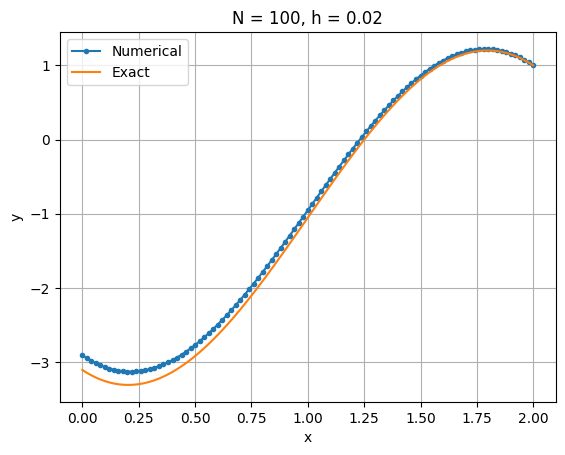

In [8]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# Discretization
L = 2
N = 100
x = np.linspace(0, L, N+1)
h = L/N

# Boundary conditions information
yN = 1
phi = -2


# Create alpha, beta, gamma, f for j = 0, 1, 2, ..., N
# Zero indexing makes for easy reference later
alpha =  1/h**2*np.ones(N+1)
beta  = -2/h**2*np.ones(N+1)
gamma =  1/h**2*np.ones(N+1)
f = 10*np.cos(np.pi*x/L)

# Set up system of equations without accounting for BCs
K = np.zeros((N-1,N-1))
R = np.zeros(N-1)
# All rows
for j in range(1, N):
    # Loop (equation) variable     j   = 1, 2, 3, ..., N-1
    # Row/column index variable    ind = 0, 1, , 2..., N-2
    # Therefore, ind = j - 1
    ind = j - 1
    # First row
    if(j==1):
        K[ind,ind]   = beta[j]
        K[ind,ind+1] = alpha[j]
    # Last row
    elif(j==N-1):
        K[ind,ind-1] = gamma[j]
        K[ind,ind]   = beta[j]
    # Middle rows
    else:
        K[ind,ind-1] = gamma[j]
        K[ind,ind]   = beta[j]
        K[ind,ind+1] = alpha[j]
    # RHS
    R[ind] = f[j]

# First row modification for Neumann condition
K[0,0] += gamma[1]
R[0]   += gamma[1]*h*phi
# Last row modification for Dirichlet condition
R[-1]  += -alpha[N-1]*yN

# Set up solve and BCs
y = np.zeros(N+1)               # Initialize
y[1:N] = np.linalg.solve(K, R)  # Solve for interior nodal values
y[0] = y[1] - h*phi             # Impose Neumann condition
y[N] = yN                       # Impose Dirichlet condition


# Plot numerical and exact solutions
xfine = np.linspace(0, L, 101)
ytrue = -10*(L/np.pi)**2*np.cos(xfine*np.pi/L) + phi*xfine + yN - 10*(L/np.pi)**2 - phi*L
plt.figure()
plt.plot(x,y,'.-',label='Numerical')
plt.plot(xfine,ytrue,label='Exact')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('N = '+str(N)+', h = '+str(h))
plt.legend()
plt.show()
